In [1]:
import healpy as hp 
import pylab as pl 

In [2]:
comap = hp.read_map('extending_CO/CO_fullsky_pred.fits', field=0 )
coplanck10 = hp.read_map ('/pscratch/sd/g/giuspugl/workstation/CO_network/HFI_CompMap_CO-Type2_2048_R2.00.fits') 
coplanck10_1024_rev = hp.ud_grade(hp.read_map ('/global/cfs/cdirs/cmb/www/Planck_Revisited/co/PlanckRevisited_CO10_NSIDE1024_lmax2048.fits') ,nside_out=2048) 



In [3]:
nans = pl.ma.masked_invalid(comap ) .mask 
comap[nans ] = pl.nanmedian(comap) 

In [4]:
pl.figure(figsize=(15,10)) 

hp.mollview(comap2   , min=-1, max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm' ) 
hp.mollview(coplanck10    ,  min=-1, max=1 , sub=131 , title="CO map (Planck 2013) ", cmap='coolwarm' ) 
hp.mollview(coplanck10_1024_rev    ,  min=-1, max=1 , sub=133 , title="CO map (Ghosh+ 2024", cmap='coolwarm'  )
hp.graticule()


NameError: name 'comap2' is not defined

<Figure size 1080x720 with 0 Axes>

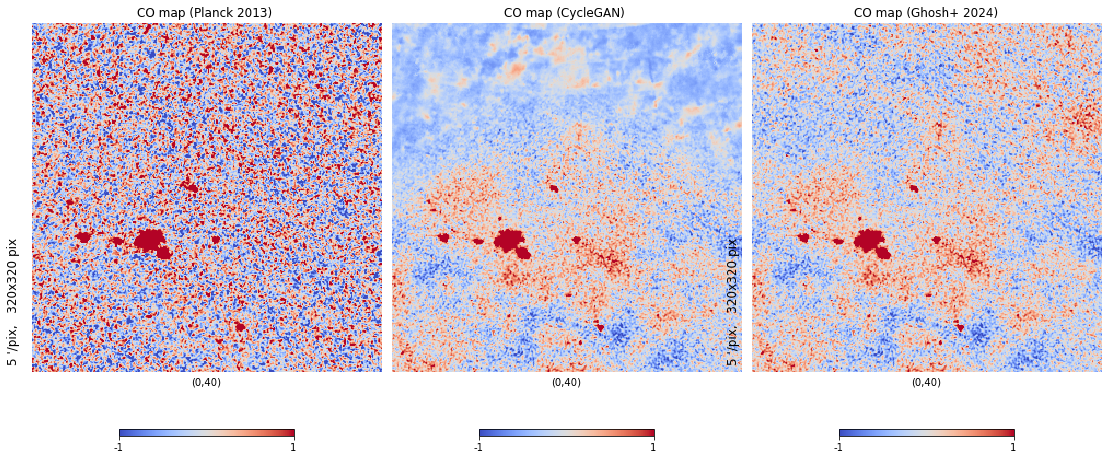

In [250]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2  , rot=[0,40], reso=5, xsize=320  ,min=-1
            ,max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm'  ) 
hp.gnomview(coplanck10_1024_rev   , rot=[0,40], reso=5, xsize=320  ,min=-1
            ,max=1 ,  sub=133, title="CO map (Ghosh+ 2024)", cmap='coolwarm' ) 
hp.gnomview(coplanck10  ,  rot=[0,40], reso=5, xsize=320  ,min=-1
            ,max=1 ,  sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )

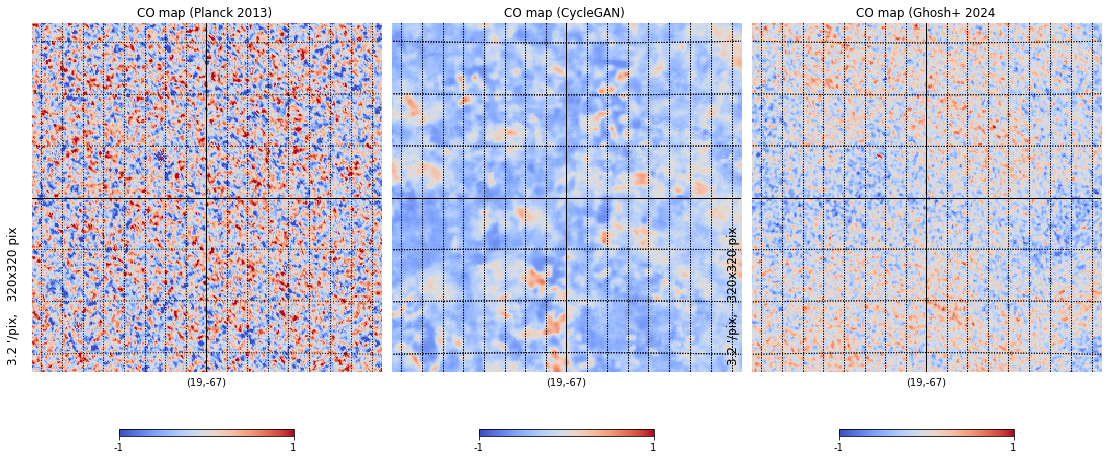

In [251]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2  , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm' ) 
hp.graticule()
hp.gnomview(coplanck10_1024_rev   , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=133, title="CO map (Ghosh+ 2024", cmap='coolwarm' ) 
hp.graticule()

hp.gnomview(coplanck10   , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )
hp.graticule()

In [136]:
mask = hp.read_map('../FG_modelling/HFI_Mask_GalPlane-apo2_2048_R2.00.fits',['GAL060'] ) 


In [137]:
mask1024 = hp.ud_grade(mask ,nside_out=1024 )

In [138]:
nans = pl.ma.masked_invalid(comap ) .mask 
comap[nans ] = pl.nanmedian(comap) 


In [139]:
def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + pl.exp(-power * (x - x0 - width / 2) / width))





# 1. rescale CO predictions masking out the Galactic plane 
$\tilde{m} = \sqrt{\frac{C_{\ell=10}}{\tilde{C}_{\ell=10}} } m_{planck}$
# 2. HPF $\tilde{m}$ , large scales observed by planck , small scales from neural net
# 3. coadd 

In [232]:
lmax= 1024
almpred_no = hp.map2alm (comap*( mask) , lmax=lmax  )
clpred_no  =hp.alm2cl(almpred_no  ) 
sigmadet= 1
almpl = hp.map2alm(coplanck10*(mask) , lmax=lmax ) 
clpl =hp.alm2cl(almpl) 
ell=pl.arange(lmax+1) 

ellpivot =100  #ell[pl.argmin(pl.fabs(clpl-clpred_no))] 

print(ellpivot) 
Aco =  pl.sqrt(clpl[ellpivot] /clpred_no[ellpivot] )/sigmadet

print(Aco ) 
almpred=Aco *almpred_no
clpred=hp.alm2cl(almpred   ) 
thetascale = pl.degrees(pl.pi/ 2 /ellpivot)


100
0.699508349797301


In [267]:
comap2= Aco * comap * mask 
clpred= hp.anafast(comap2, lmax=lmax) 

In [ ]:
almpl_rev = hp.map2alm(coplanck10_1024_rev*(mask1024) , lmax=lmax ) 


(1e-08, 0.1)

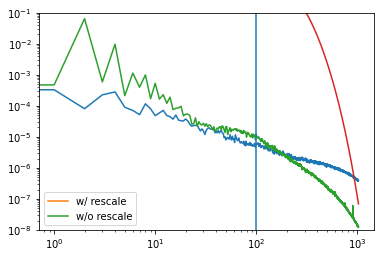

In [268]:
fl = sigmoid(ell, x0=ellpivot, width=ellpivot /.5)
#fl = 1- hp.gauss_beam(lmax=lmax, fwhm=pl.radians(thetascale)) 

pl.loglog(clpl  ) 
pl.loglog(clpred ,label='w/ rescale') 
pl.loglog(clpred_no , label='w/o rescale') 
pl.loglog(1-fl) 
pl.axvline(ellpivot ) 


pl.legend() 
pl.ylim (1e-8, 1e-1) 

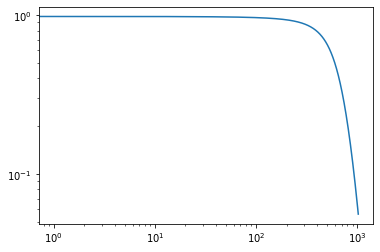

In [202]:
pl.loglog(1-fl) 


In [203]:
almpl_h_f =hp.almxfl(almpl, 1- fl)
almpred_f =hp.almxfl(almpred , fl)


almtot_h = almpl_h_f + almpred_f

(1e-08, 0.1)

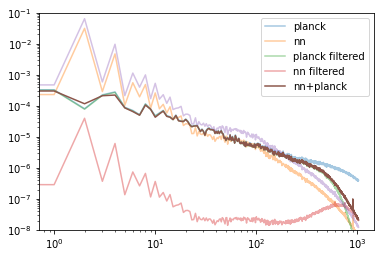

In [234]:

clpl_f = hp.alm2cl(almpl_h_f, lmax=lmax ) 
clpred_f = hp.alm2cl(almpred_f, lmax=lmax ) 
cltot_h = hp.alm2cl(almtot_h, lmax=lmax ) 
pl.loglog(clpl ,alpha=.4, label = 'planck' ) 
pl.loglog(clpred,alpha=.4 , label='nn') 
pl.loglog(clpl_f ,alpha=.4, label='planck filtered' ) 
pl.loglog(clpred_f ,alpha=.4, label='nn filtered' ) 
pl.loglog(clpred_no ,alpha=.4,) 
pl.loglog(cltot_h  ,label= 'nn+planck' ) 
pl.legend() 


pl.ylim (1e-8, 1e-1) 

In [205]:
map_h = hp.alm2map(almtot_h, nside =hp.get_nside(coplanck10), lmax=lmax )



In [244]:
comap2 = map_h * mask +coplanck10*(1-mask )

 
 

ValueError: operands could not be broadcast together with shapes (12582912,) (50331648,) 

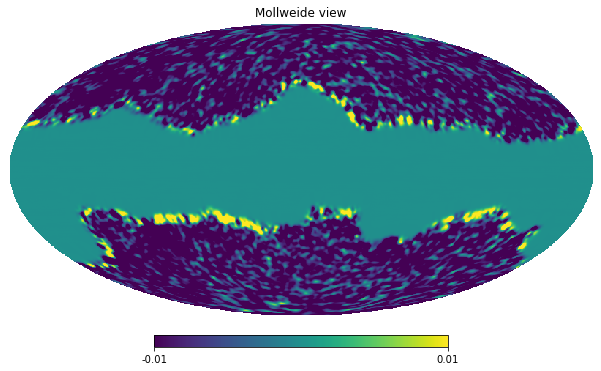

In [207]:
ms = hp.smoothing(comap2, fwhm=pl.radians(2),lmax=lmax )
mpls  = hp.smoothing(coplanck10, fwhm=pl.radians(2),lmax=lmax )
hp.mollview(ms  -mpls , min=-.01, max=.01  )





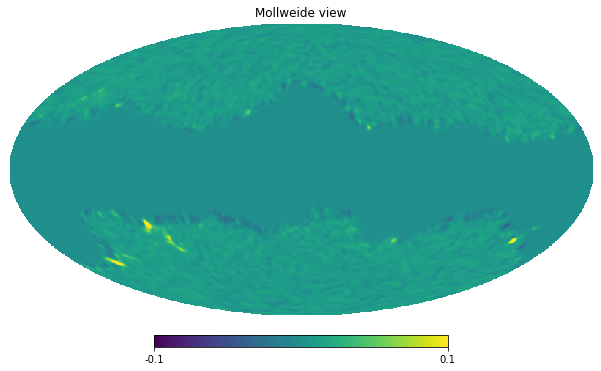

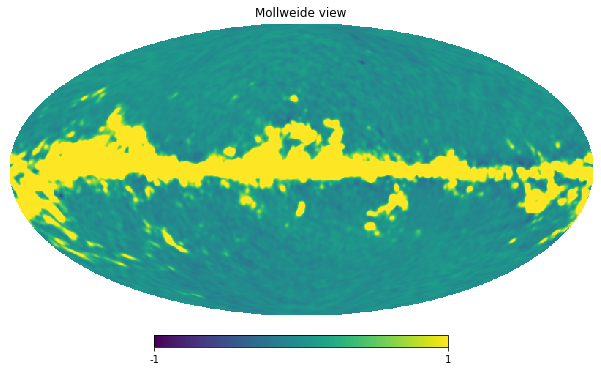

In [208]:
hp.mollview(mpls-ms , min=-.1, max=.1)
hp.mollview(mpls, min=-1, max=1)

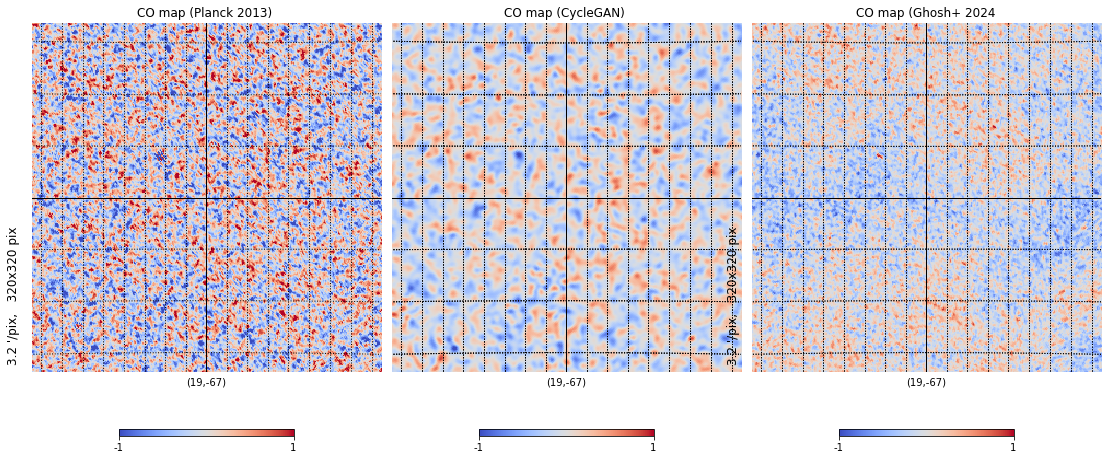

In [209]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2   , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm' ) 
hp.graticule()
hp.gnomview(coplanck10_1024_rev   , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=133, title="CO map (Ghosh+ 2024", cmap='coolwarm' ) 
hp.graticule()

hp.gnomview(coplanck10   , rot=[19,-67], reso=3.2, xsize=320  ,min=-1
            ,max=1 , sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )
hp.graticule()


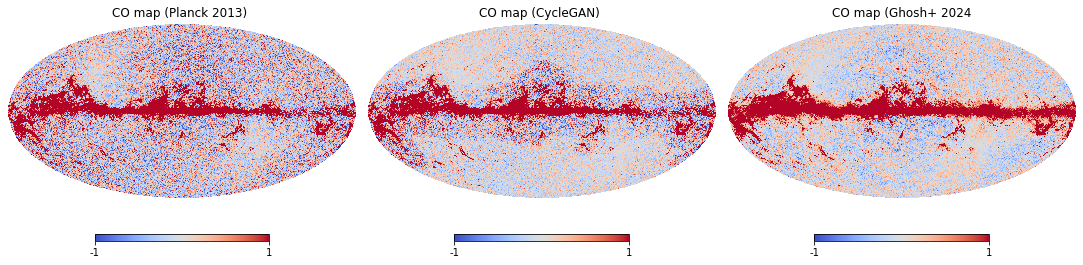

In [210]:
pl.figure(figsize=(15,10)) 

hp.mollview(comap2   , min=-1, max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm' ) 
hp.mollview(coplanck10    ,  min=-1, max=1 , sub=131 , title="CO map (Planck 2013) ", cmap='coolwarm' ) 
hp.mollview(coplanck10_1024_rev    ,  min=-1, max=1 , sub=133 , title="CO map (Ghosh+ 2024", cmap='coolwarm'  ) 

(1e-08, 0.1)

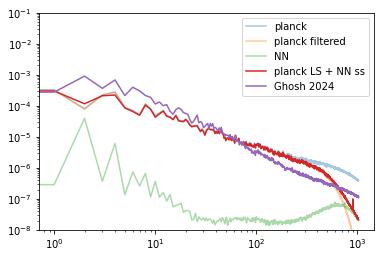

In [211]:
clpl_rev = hp.anafast(coplanck10_1024_rev*mask1024 , lmax=lmax) 


clpl_f = hp.alm2cl(almpl_h_f, lmax=lmax) 
clpred_f = hp.alm2cl(almpred_f, lmax=lmax ) 
cltot_h = hp.alm2cl(almtot_h, lmax=lmax ) 
pl.loglog(clpl ,alpha=.4, label='planck'  ) 
#pl.loglog(cl1,alpha=.4 ) 
pl.loglog(clpl_f ,alpha=.4, label='planck filtered' ) 
pl.loglog(clpred_f ,alpha=.4, label='NN' ) 
pl.loglog(cltot_h  , label= 'planck LS + NN ss' ) 
pl.loglog(clpl_rev , label='Ghosh 2024'  ) 

pl.legend() 

pl.ylim (1e-8, 1e-1) 

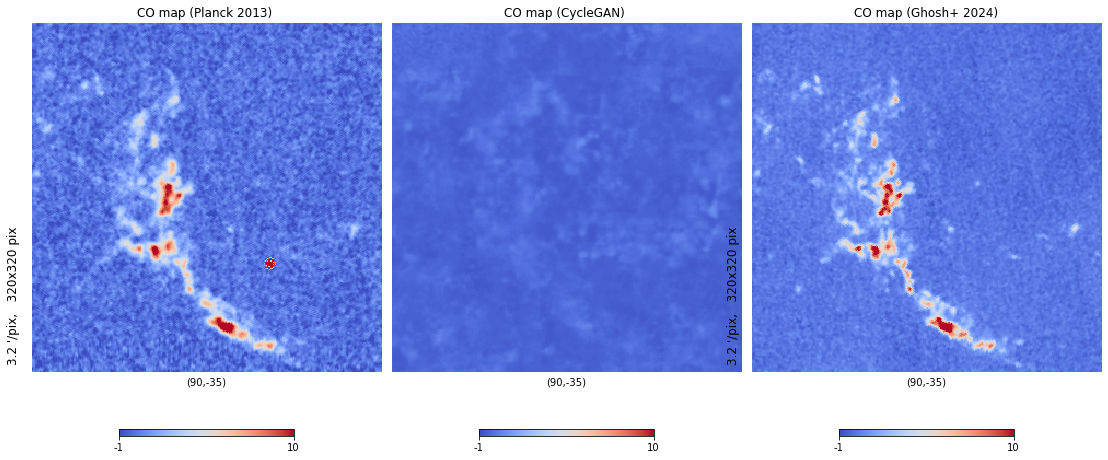

In [252]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2   , rot=[90,-35], reso=3.2, xsize=320  ,min=-1
            ,max=10 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm'  ) 
hp.gnomview(coplanck10_1024_rev   , rot=[90,-35], reso=3.2, xsize=320  ,min=-1
            ,max=10 ,  sub=133, title="CO map (Ghosh+ 2024)", cmap='coolwarm' ) 
hp.gnomview(coplanck10  ,  rot=[90,-35], reso=3.2, xsize=320  ,min=-1
            ,max=10 ,  sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )

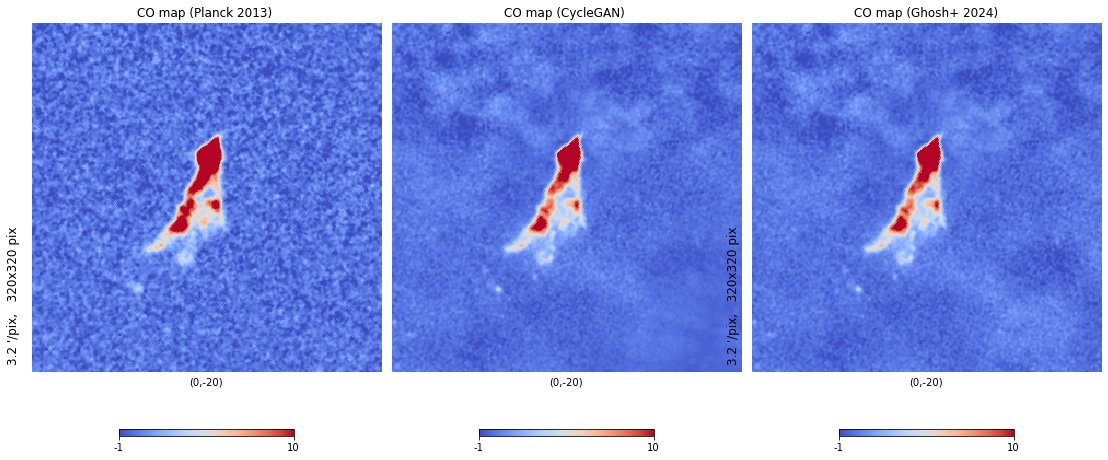

In [253]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2   , rot=[0,-20], reso=3.2, xsize=320  ,min=-1
            ,max=10 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm'  ) 
hp.gnomview(coplanck10_1024_rev   , rot=[0,-20], reso=3.2, xsize=320  ,min=-1
            ,max=10 ,  sub=133, title="CO map (Ghosh+ 2024)", cmap='coolwarm' ) 
hp.gnomview(coplanck10  ,  rot=[0,-20], reso=3.2, xsize=320  ,min=-1
            ,max=10 ,  sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )

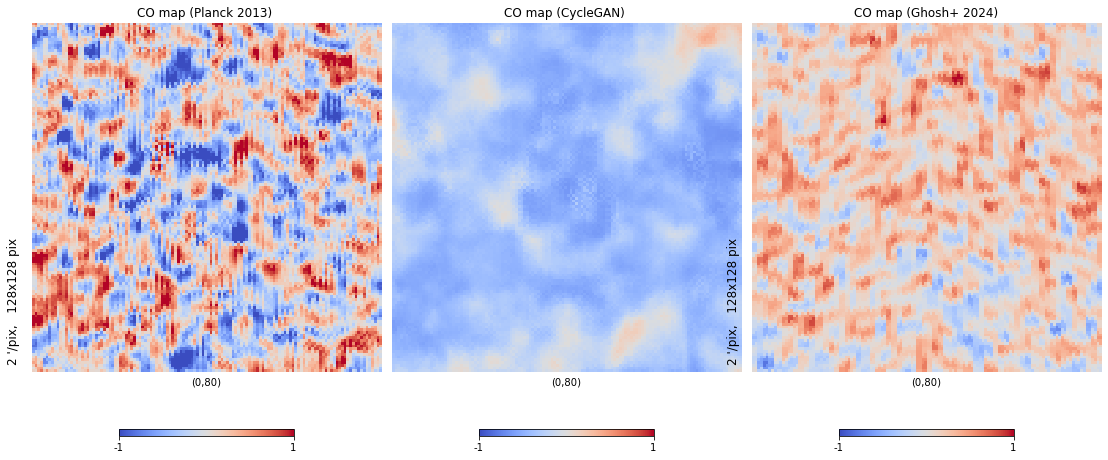

In [254]:
pl.figure(figsize=(15,10)) 
hp.gnomview(comap2   , rot=[0,80], reso=2, xsize=128  ,min=-1
            ,max=1 , sub=132, title="CO map (CycleGAN) ", cmap='coolwarm'  ) 
hp.gnomview(coplanck10_1024_rev   , rot=[0,80], reso=2, xsize=128  ,min=-1
            ,max=1 ,  sub=133, title="CO map (Ghosh+ 2024)", cmap='coolwarm' ) 
hp.gnomview(coplanck10  ,  rot=[0,80], reso=2, xsize=128  ,min=-1
            ,max=1 ,  sub=131, title="CO map (Planck 2013) ", cmap='coolwarm' )

In [23]:
dust = hp.read_map('extending_CO/COM_CompMap_Dust-GNILC-F857_2048_R2.00_15amin.fits') 

In [24]:
hi= hp.read_map('extending_CO/NHI_HI4Pi_16amin_nside2048_inpainted.fits') 

In [255]:
cl_coxhi = hp.anafast(map1=comap2*mask , map2=hi*mask , lmax=lmax ) 
cl_coco = hp.anafast(map1=comap2*mask  , lmax=lmax ) 
cl_hihi = hp.anafast(map1=hi*mask  , lmax=lmax ) 

cl_coxd = hp.anafast(map1=comap2*mask  ,map2=dust*mask  ,lmax=lmax ) 
cl_dd = hp.anafast(map1=dust*mask  , lmax=lmax ) 


409600

In [256]:
cl_coxhi_pl = hp.anafast(map1=coplanck10*mask , map2=hi*mask , lmax=lmax ) 
cl_coco_pl = hp.anafast(map1=coplanck10*mask  , lmax=lmax ) 

cl_coxd_pl = hp.anafast(map1=coplanck10*mask  ,map2=dust*mask  ,lmax=lmax ) 


In [257]:
cl_coxcopl = hp.anafast(map1=comap2*mask  ,map2=coplanck10*mask  ,lmax=lmax ) 


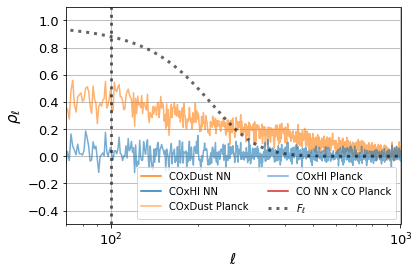

In [258]:
pl.semilogx(ell, cl_coxd/pl.sqrt(cl_coco*cl_dd), color="C1", alpha=1, label= 'COxDust NN') 
pl.semilogx(ell, cl_coxhi/pl.sqrt(cl_coco*cl_hihi), color="C0",alpha=1 , label= 'COxHI NN') 
pl.semilogx(ell, cl_coxd_pl/pl.sqrt(cl_coco_pl*cl_dd), color="C1", alpha=.6, label= 'COxDust Planck' ) 
pl.semilogx(ell, cl_coxhi_pl/pl.sqrt(cl_coco_pl*cl_hihi), color="C0",alpha=.6 , label= 'COxHI Planck') 
pl.semilogx(ell, cl_coxcopl/pl.sqrt(cl_coco_pl*cl_coco), color='C3' , label= 'CO NN x CO Planck' ) 
pl.semilogx(ell, 1-fl,':', lw=3, alpha=.6,color='black', label=r'$F_{\ell}$')
pl.axvline(ellpivot, linestyle=':', lw=3, alpha=.6,color='black' )
pl.xlim(70,1000) 
pl.ylim(-0.5,1.1) 

pl.ylabel (r'$\rho_{\ell}$', fontsize=15) 
pl.xlabel (r'${\ell}$', fontsize=15) 
pl.xticks( fontsize=13)
pl.yticks( fontsize=13)
pl.legend(ncol=2)
pl.grid(True )

In [219]:
fl = sigmoid(ell, x0=ellpivot, width=ellpivot /.5) 
almpl_filt =hp.almxfl (almpl,fl =fl )#pl.ones(lmax)   )
almpl_rev_filt =hp.almxfl (almpl_rev, fl=fl )#pl.ones(lmax)  )
almpred_filt =hp.almxfl (almtot_h, fl=fl )#pl.ones(lmax)   )


In [220]:
cl_predxpl  =hp.alm2cl(almpred_filt, alms2=almpl_filt, lmax=lmax )  
cl_revxpl= hp.alm2cl(almpl_rev_filt, alms2=almpl_filt, lmax=lmax )  
cl_predxrev= hp.alm2cl(almpl_rev_filt, alms2=almpred_filt, lmax=lmax )  

cl_pred_f = hp.alm2cl(almpred_filt) 
cl_pl_f = hp.alm2cl(almpl_filt) 
cl_pl_rev_f = hp.alm2cl(almpl_rev_filt) 

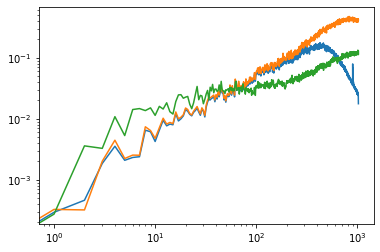

In [221]:
cl_co_rev= hp.alm2cl(almpl_rev) 

ell= pl.arange(lmax+1) 
pl.loglog(cl_coco*ell**2  ) 
pl.loglog(cl_coco_pl*ell**2  ) 
pl.loglog(cl_co_rev*ell**2  ) 